In [ ]:
import os
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import kaiming_normal_, constant_
from torchvision import models
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as imshow
from imageio import imread, imwrite
from torchvision.io import read_video
import torchvision.transforms.functional as FF
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
from torchvision.utils import flow_to_image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
flownets_path = '/content/gdrive/MyDrive/OpticalFlow/flownets_EPE1.951.pth'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#Dataset loader and transformer
class ArrayToTensor(object):
    """Converts a numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)."""

    def __call__(self, array):
        assert(isinstance(array, np.ndarray))
        array = np.transpose(array, (2, 0, 1))
        # handle numpy array
        tensor = torch.from_numpy(array)
        # put it from HWC to CHW format
        return tensor.float()

input_transform = transforms.Compose([
    ArrayToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
    transforms.Normalize(mean=[0.411,0.432,0.45], std=[1,1,1])
])

In [ ]:
#Defining functions
def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )

def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)


def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )

def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

In [ ]:
#Defining Model FlowNetS

class FlowNetS(nn.Module):
    expansion = 1

    def __init__(self,batchNorm=True):
        super(FlowNetS,self).__init__()

        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]

def flownets(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)

    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=False)
    # print(data)
    if data is not None:
        model.load_state_dict(data['state_dict'])

    return model

def flownets_bn(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)

    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=True)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model

FlowNetS = flownets(torch.load(flownets_path, map_location = device))
FlowNetS.eval()

<ipython-input-7-fc934b805809>:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  FlowNetS = flownets(torch.load(flownets_path, map_location = device))


FlowNetS(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4_1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512,

In [ ]:
import cv2
import os
import numpy as np
import torch
#Instead of colab specific import use this:
from IPython.display import display # or 'from google.colab.patches import cv2_imshow' if in Colab
from torchvision.utils import flow_to_image

Images1 = '/content/gdrive/MyDrive/OpticalFlow/Images1/'
Images2 = '/content/gdrive/MyDrive/OpticalFlow/Images2/'
Flow = '/content/gdrive/MyDrive/OpticalFlow/Flow/'

def save_flo(flow, filename):
    """Saves optical flow in .flo format (Middlebury standard)."""
    with open(filename, 'wb') as f:
        f.write(b'PIEH')  # Magic number
        f.write(np.array([flow.shape[1], flow.shape[0]], dtype=np.int32).tobytes())  # Width, height
        f.write(flow.astype(np.float32).tobytes())  # Flow data


# Inference Loop
for i in range(10):
    temp = i + 1
    img1_file = f'view1_{temp}.png'
    img2_file = f'view2_{temp}.png'

    img1_i = imread(os.path.join(Images1, img1_file))
    img2_i = imread(os.path.join(Images2, img2_file))

    img1 = input_transform(img1_i)
    img2 = input_transform(img2_i)

    input_var = torch.cat([img1, img2]).unsqueeze(0).to(device)

    output = FlowNetS(input_var)
    print(output.shape)

    for suffix, flow_output in zip(['flow', 'inv_flow'], output):

      predicted_flow_resized = F.interpolate(flow_output.unsqueeze(0), size=(img1_i.shape[0], img1_i.shape[1]), mode='bilinear', align_corners=False).squeeze(0)
      predicted_flow = predicted_flow_resized.detach().cpu().numpy().transpose(1, 2, 0)

      output_filename = f"flow_{temp}.flo"
      save_flo(predicted_flow, os.path.join(Flow, output_filename))

    print(f"Optical flow saved as flow {temp}")

<ipython-input-8-58759cf5dd74>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1_i = imread(os.path.join(Images1, img1_file))
<ipython-input-8-58759cf5dd74>:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2_i = imread(os.path.join(Images2, img2_file))


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

<ipython-input-9-fd53cca947c2>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread(os.path.join(data_path1, img1_file))
<ipython-input-9-fd53cca947c2>:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imread(os.path.join(data_path2, img2_file))


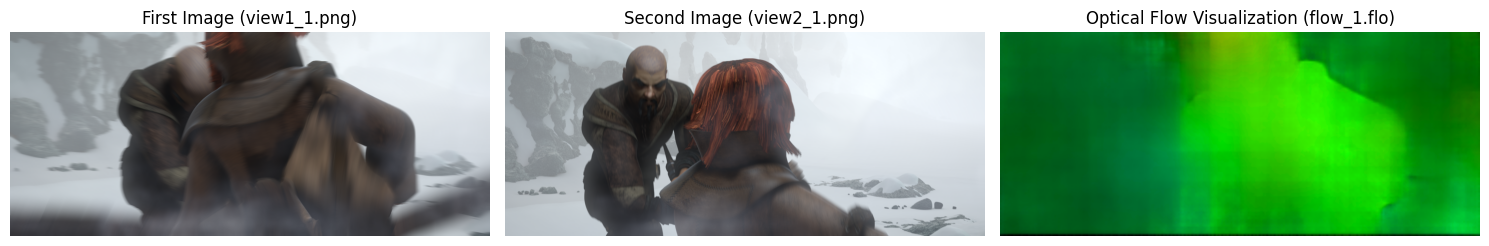

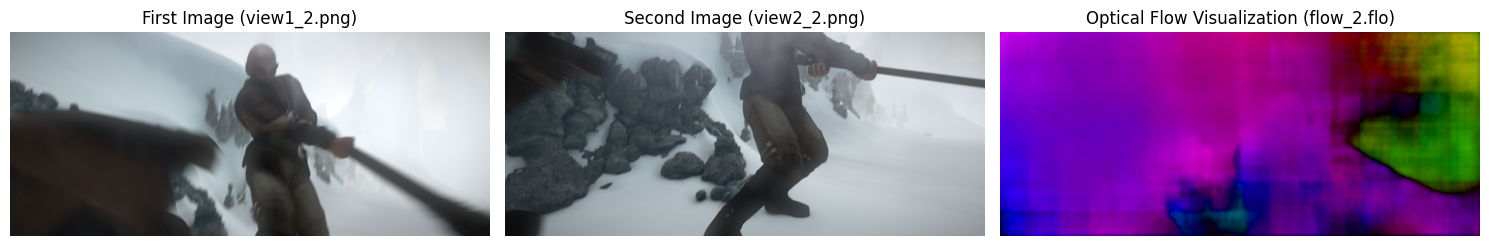

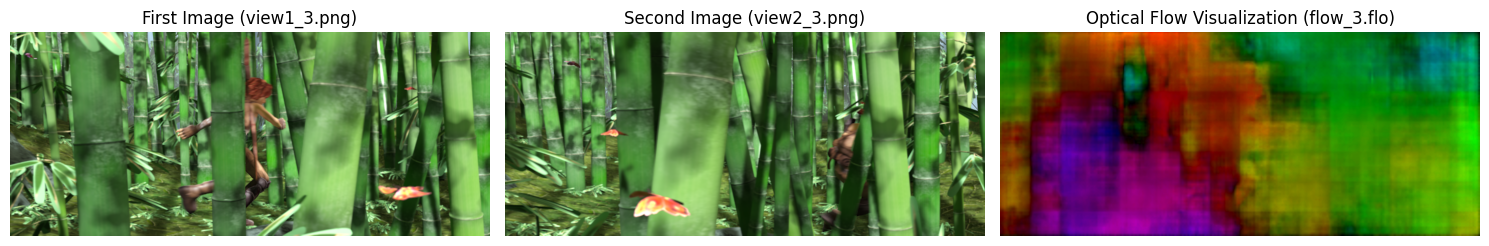

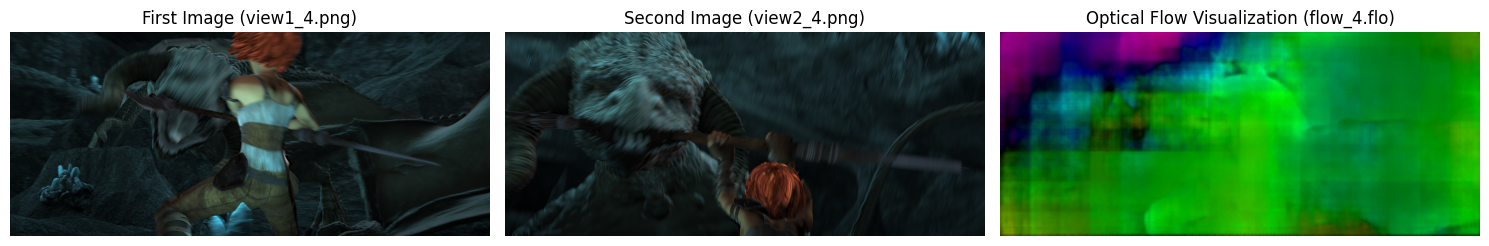

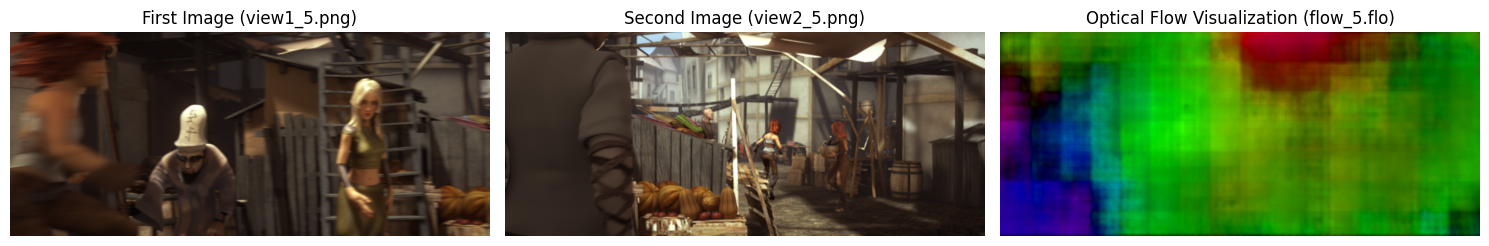

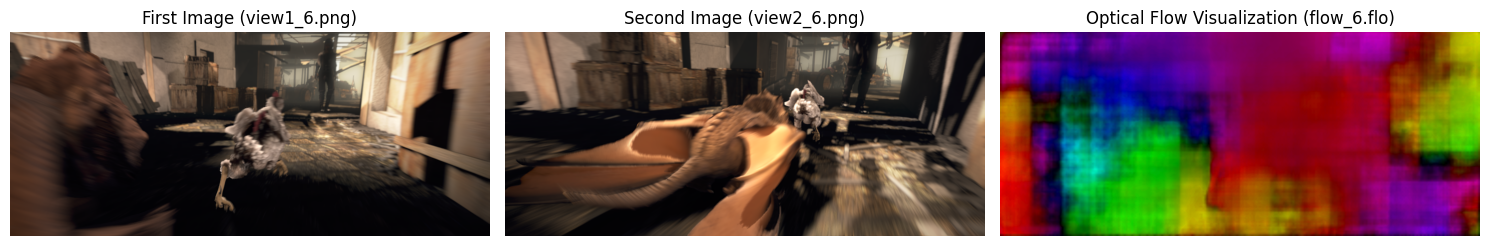

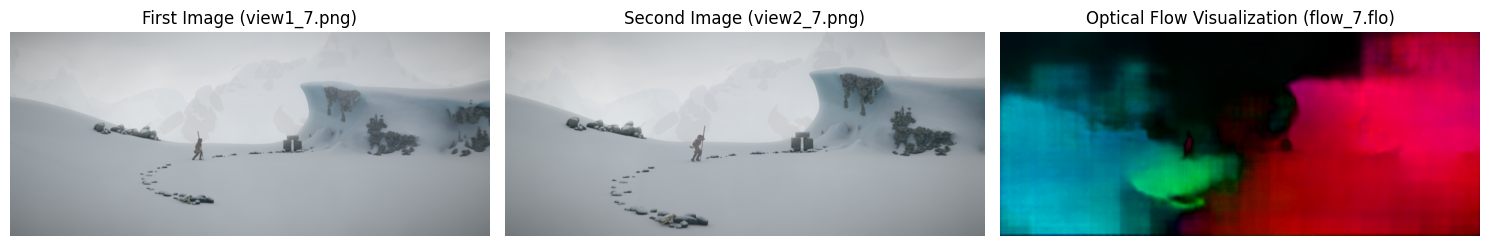

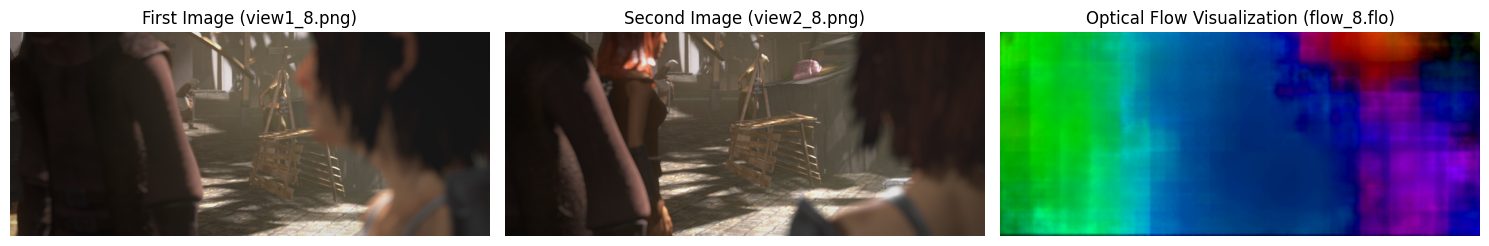

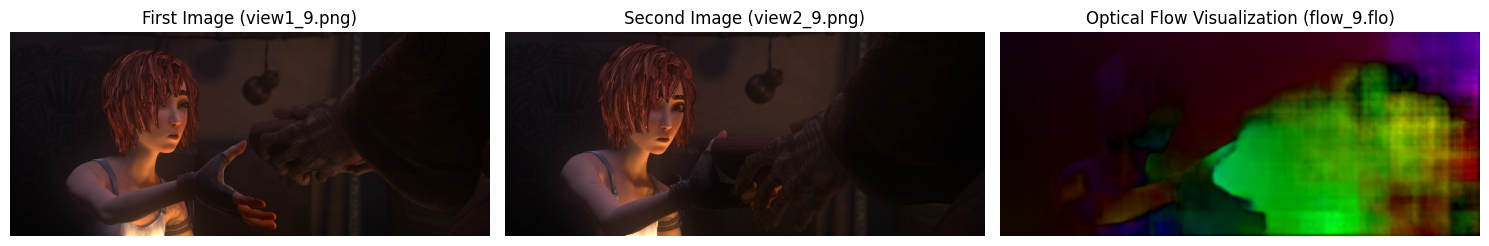

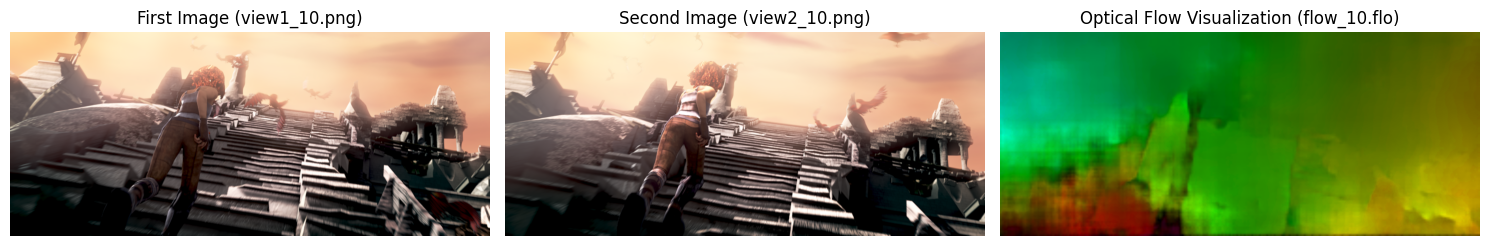

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imageio import imread
import os

def read_flo_file(filename):
    """Reads a .flo file and returns the optical flow as a NumPy array."""
    with open(filename, 'rb') as f:
        magic = f.read(4)
        if magic != b'PIEH':
            raise ValueError("Invalid .flo file format")
        w, h = np.frombuffer(f.read(8), dtype=np.int32)
        flow = np.frombuffer(f.read(), dtype=np.float32).reshape(h, w, 2)
    return flow

def flow_to_rgb(flow):
    """Convert optical flow to RGB using HSV color encoding."""
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)

    # Compute magnitude and angle of flow vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Normalize angle to [0, 180] for HSV hue
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255  # Max saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Normalize magnitude

    # Convert HSV to RGB
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

# Paths to data directories
data_path1 = "/content/gdrive/MyDrive/OpticalFlow/Images1/"  # First set of images
data_path2 = "/content/gdrive/MyDrive/OpticalFlow/Images2/"  # Second set of images
flow_path = "/content/gdrive/MyDrive/OpticalFlow/Flow/"  # Flow files

# Process 10 image pairs
for i in range(1, 11):  # Loop from 1 to 10
    img1_file = f"view1_{i}.png"
    img2_file = f"view2_{i}.png"
    flow_file = f"flow_{i}.flo"

    # Load images and optical flow
    img1 = imread(os.path.join(data_path1, img1_file))
    img2 = imread(os.path.join(data_path2, img2_file))
    flow = read_flo_file(os.path.join(flow_path, flow_file))

    # Convert flow to an RGB visualization
    flow_rgb = flow_to_rgb(flow)

    # Plot the images and the flow visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img1)
    axes[0].set_title(f"First Image ({img1_file})")
    axes[0].axis("off")

    axes[1].imshow(img2)
    axes[1].set_title(f"Second Image ({img2_file})")
    axes[1].axis("off")

    axes[2].imshow(flow_rgb)
    axes[2].set_title(f"Optical Flow Visualization ({flow_file})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


Part - B


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [ ]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve

video_folder = "/content/gdrive/MyDrive/Interstellar_flownets_finetuning/"

video_path = video_folder + "Interstellar_v7.m4v"


In [ ]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path))
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

img1_batch = torch.stack([frames[0], frames[1]])
img2_batch = torch.stack([frames[118], frames[119]])

plot(img1_batch)

In [ ]:
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

In [ ]:
from torchvision.models.optical_flow import raft_large

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

In [ ]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

In [ ]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models.optical_flow import raft_large
from torchvision.utils import flow_to_image
import os

# Set the paths
video_folder = "/content/gdrive/MyDrive/Interstellar_flownets_finetuning/"
img1_folder = os.path.join(video_folder, "img1/")
img2_folder = os.path.join(video_folder, "img2/")
flow_folder = os.path.join(video_folder, "flow_output/")

# Create output folders if they don't exist
os.makedirs(img1_folder, exist_ok=True)
os.makedirs(img2_folder, exist_ok=True)
os.makedirs(flow_folder, exist_ok=True)

# Initialize the RAFT model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = raft_large(pretrained=True, progress=False).to(device).eval()


In [ ]:
# Preprocessing function
def preprocess(batch):
    transforms = T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5),  # Map [0, 1] into [-1, 1]
        T.Resize(size=(520, 960))
    ])
    return transforms(batch)

def save_flo(flow, filename):
    """
    Saves a flow tensor in .flo format.

    Args:
        flow (torch.Tensor): Optical flow of shape (2, H, W).
        filename (str): Output file path.
    """
    H, W = flow.shape[1], flow.shape[2]

    # Convert flow tensor to numpy array
    flow_np = flow.cpu().numpy().astype(np.float32)  # (2, H, W)
    flow_np = np.transpose(flow_np, (1, 2, 0))  # Convert to (H, W, 2)

    with open(filename, "wb") as f:
        f.write(struct.pack("4s", b"PIEH"))  # Magic number
        f.write(struct.pack("i", W))  # Width
        f.write(struct.pack("i", H))  # Height
        f.write(flow_np.tobytes())  # Flow data

# Process each video
for i in range(1, 31):  # Loop for 30 videos
    video_path = os.path.join(video_folder, f"Interstellar_v{i}.m4v")

    if not os.path.exists(video_path):
        print(f"Skipping {video_path} (file not found)")
        continue

    print(f"Processing {video_path}...")

    # Read video frames
    frames, _, _ = read_video(video_path)
    frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

    # Select frames for optical flow computation
    if frames.shape[0] < 40:  # Skip videos with less than 40 frames
        print(f"Skipping {video_path} (not enough frames)")
        continue

    img1_batch = torch.stack([frames[10], frames[11]])
    img2_batch = torch.stack([frames[118], frames[119]])

    # Save img1 and img2
    for idx, img in enumerate(img1_batch):
        img_path = os.path.join(img1_folder, f"img1_v{i}_{idx}.png")
        F.to_pil_image(img.cpu()).save(img_path)

    for idx, img in enumerate(img2_batch):
        img_path = os.path.join(img2_folder, f"img2_v{i}_{idx}.png")
        F.to_pil_image(img.cpu()).save(img_path)

    # Preprocess images
    img1_batch = preprocess(img1_batch).to(device)
    img2_batch = preprocess(img2_batch).to(device)

    # Predict optical flow
    list_of_flows = model(img1_batch, img2_batch)
    predicted_flows = list_of_flows[-1]  # Shape: (N, 2, H, W)

    # Save optical flow in .flo format
    for idx, flow in enumerate(predicted_flows):
        flo_path = os.path.join(flow_folder, f"flow_v_f{i}_{idx}.flo")
        save_flo(flow, flo_path)

    print(f"Finished processing {video_path}\n")

print("✅ All videos processed successfully!")

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

##############################################
# 1) FlowNetS Model Definition (as provided)
##############################################
from torch.nn.init import kaiming_normal_, constant_

def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                      padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1, inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                      padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1, inplace=True)
        )

def predict_flow(in_planes):
    return nn.Conv2d(in_planes, 2, kernel_size=3, stride=1, padding=1, bias=False)

def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1, inplace=True)
    )

def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

class FlowNetS(nn.Module):
    expansion = 1
    def __init__(self, batchNorm=True):
        super(FlowNetS, self).__init__()
        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512,1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024,1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5, out_deconv5, flow6_up), 1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4, out_deconv4, flow5_up), 1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3, out_deconv3, flow4_up), 1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2, out_deconv2, flow3_up), 1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2, flow3, flow4, flow5, flow6
        else:
            return flow2

def flownets(data=None):
    model = FlowNetS(batchNorm=False)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model

##############################################
# 2) Dataset for Fine-Tuning using Saved Frames & Flow
##############################################
class FlowFineTuneDataset(Dataset):
    """
    Dataset for fine-tuning.
    Each sample is contained in a folder under samples_dir (e.g., output/samples/sample0)
    and includes:
       - image1.png (first frame)
       - image2.png (second frame)
       - flow.npy (ground truth flow: shape [2, H, W])
       - flow_vis.png (visualization; not used for training)

    The input is created by concatenating image1 and image2 along the channel dimension,
    resulting in a tensor of shape [6, H, W].
    """
    def __init__(self, samples_dir1, samples_dir2, samples_dirf, transform=None):
        self.samples_dir1 = samples_dir1
        self.samples_dir2 = samples_dir2
        self.samples_dirf = samples_dirf
        # # List all subfolders and filter those that have all required files.
        # all_folders = sorted([os.path.join(samples_dir, d) for d in os.listdir(samples_dir)
        #                       if os.path.isdir(os.path.join(samples_dir, d))])
        # self.sample_folders = []
        # for folder in all_folders:
        #     image1_path = os.path.join(folder, "image1.png")
        #     image2_path = os.path.join(folder, "image2.png")
        #     flow_path   = os.path.join(folder, "flow.npy")
        #     if os.path.isfile(image1_path) and os.path.isfile(image2_path) and os.path.isfile(flow_path):
        #         self.sample_folders.append(folder)
        #     else:
        #         print(f"Skipping folder {folder} because one or more required files are missing.")
        self.transform = transform
        # Assuming each directory has the same number of files
        self.samples = sorted(os.listdir(samples_dir1))

    def __len__(self):
        return int(len(self.samples)/2)

    def __getitem__(self, idx):
        sample_folder1 = self.samples_dir1
        sample_folder2 = self.samples_dir2
        sample_folderf = self.samples_dirf
        # sample_folder = self.sample_folders[idx]
        image1_path = os.path.join(sample_folder1, f"img1_v{idx+1}_0.png")
        image2_path = os.path.join(sample_folder2, f"img2_v{idx+1}_0.png")
        flow_path   = os.path.join(sample_folderf, f"flow_v{idx+1}_0.npy")

        # Load images using cv2 and convert from BGR to RGB.
        img1 = cv2.imread(image1_path)
        img2 = cv2.imread(image2_path)
        if img1 is None or img2 is None:
            raise FileNotFoundError(f"Missing image in sample folder: {sample_folder1}")
        if img1.shape != img2.shape:
            raise ValueError(f"Images have different shapes: {img1.shape} vs {img2.shape}")

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # Convert images to float32 in [0, 1].
        img1 = img1.astype(np.float32) / 255.0
        img2 = img2.astype(np.float32) / 255.0

        if self.transform:
            # The transform expects a PIL image.
            img1 = transforms.ToPILImage()(img1)
            img2 = transforms.ToPILImage()(img2)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        else:
            # Default conversion: HWC to CHW and then to tensor.
            img1 = torch.from_numpy(img1.transpose(2, 0, 1))
            img2 = torch.from_numpy(img2.transpose(2, 0, 1))

        # Concatenate images along the channel dimension: [6, H, W].
        input_tensor = torch.cat([img1, img2], dim=0)

        # Load ground truth flow.
        gt_flow = np.load(flow_path)  # Expected shape: [2, H, W]
        gt_flow = torch.from_numpy(gt_flow).float()

        sample = {'input': input_tensor, 'gt_flow': gt_flow}
        return sample

##############################################
# 3) Fine-Tuning Script
##############################################
def flow_accuracy(pred_flow, gt_flow, threshold=3.0):
    """
    Computes the percentage of pixels with endpoint error less than the threshold.
    pred_flow and gt_flow are expected to be of shape [B, 2, H, W].
    """
    # Compute endpoint error per pixel.
    epe = torch.norm(pred_flow - gt_flow, dim=1)  # [B, H, W]
    # Percentage of pixels with error less than threshold.
    correct = (epe < threshold).float().mean() * 100.0
    return correct.item()

if __name__ == "__main__":
    # Define a default transform to resize all images to a fixed size.
    # Change (256, 256) to your desired size.
    default_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Path to the samples directory.
    samples_dir1 = "/content/gdrive/MyDrive/Interstellar_flownets_finetuning/img1/"
    samples_dir2 = "/content/gdrive/MyDrive/Interstellar_flownets_finetuning/img2/"
    samples_dirf = "/content/gdrive/MyDrive/Interstellar_flownets_finetuning/flow_output/"

    # Create dataset with the default transform.
    dataset = FlowFineTuneDataset(samples_dir1, samples_dir2, samples_dirf, transform=default_transform)
    total_samples = len(dataset)
    print(f"Total samples: {total_samples}")

    # Divide dataset: 80% train, 20% validation.
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size
    print(dataset)
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # Create dataloaders that cover all samples in one batch.
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0)

    # Load pretrained FlowNetS model.
    flownets_path = "/content/gdrive/MyDrive/OpticalFlow/flownets_EPE1.951.pth"  # Update with the correct path to pretrained weights.
    state = torch.load(flownets_path, map_location='cpu')
    model = flownets(state)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()

    # Define loss function and optimizer.
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for i, sample in enumerate(train_loader):
            input_tensor = sample['input'].to(device)   # shape: [B, 6, H, W]
            gt_flow = sample['gt_flow'].to(device)        # shape: [B, 2, H, W]
            gt_flow = gt_flow[:, :2, :, :]  # Keep only the first two channels if extra exist
            optimizer.zero_grad()
            outputs = model(input_tensor)
            if isinstance(outputs, (tuple, list)):
                pred_flow = outputs[0]  # Use the finest scale output.
            else:
                pred_flow = outputs

            # Upsample predicted flow to match ground truth size.
            pred_flow_up = nn.functional.interpolate(pred_flow, size=(gt_flow.shape[2], gt_flow.shape[3]), mode='bilinear', align_corners=False)
            loss = criterion(pred_flow_up, gt_flow)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Training Average Loss: {epoch_loss:.4f}")

        # Validate.
        model.eval()
        val_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0
        with torch.no_grad():
            for sample in val_loader:
                input_tensor = sample['input'].to(device)
                gt_flow = sample['gt_flow'].to(device)
                gt_flow = gt_flow[:, :2, :, :]  # Keep only the first two channels if extra exist

                outputs = model(input_tensor)
                if isinstance(outputs, (tuple, list)):
                    pred_flow = outputs[0]
                else:
                    pred_flow = outputs

                pred_flow_up = nn.functional.interpolate(
                                  pred_flow,
                                  size=(gt_flow.shape[2], gt_flow.shape[3]),  # Ensure this matches correctly
                                  mode='bilinear',
                                  align_corners=False
                              )

                print("pred_flow_up shape",pred_flow_up.shape)
                print("gt_flow shape",gt_flow.shape)
                loss = criterion(pred_flow_up, gt_flow)
                val_loss += loss.item()
                # Compute accuracy percentage for the batch.
                acc = flow_accuracy(pred_flow_up, gt_flow, threshold=3.0)
                total_accuracy += acc
                num_batches += 1
        val_loss /= len(val_loader)
        avg_accuracy = total_accuracy / num_batches
        print(f"Epoch [{epoch+1}/{num_epochs}] Validation Average Loss: {val_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Validation Accuracy: {avg_accuracy:.2f}%")

    # Save the fine-tuned model.
    torch.save(model.state_dict(), "finetuned_flownets.pth")
    print("Fine-tuning complete. Model saved as finetuned_flownets.pth")

Total samples: 30
Training samples: 24, Validation samples: 6


<ipython-input-10-95c512e4ba22>:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(flownets_path, map_location='cpu')


Epoch [1/10], Loss: 1.9830
Epoch [1/10] Training Average Loss: 1.9830
pred_flow_up shape torch.Size([6, 2, 520, 960])
gt_flow shape torch.Size([6, 2, 520, 960])
Epoch [1/10] Validation Average Loss: 1.3972
Epoch [1/10] Validation Accuracy: 74.26%
Epoch [2/10], Loss: 1.4065
Epoch [2/10] Training Average Loss: 1.4065
pred_flow_up shape torch.Size([6, 2, 520, 960])
gt_flow shape torch.Size([6, 2, 520, 960])
Epoch [2/10] Validation Average Loss: 0.8678
Epoch [2/10] Validation Accuracy: 93.78%
Epoch [3/10], Loss: 0.8747
Epoch [3/10] Training Average Loss: 0.8747
pred_flow_up shape torch.Size([6, 2, 520, 960])
gt_flow shape torch.Size([6, 2, 520, 960])
Epoch [3/10] Validation Average Loss: 0.7248
Epoch [3/10] Validation Accuracy: 96.09%
Epoch [4/10], Loss: 0.7085
Epoch [4/10] Training Average Loss: 0.7085
pred_flow_up shape torch.Size([6, 2, 520, 960])
gt_flow shape torch.Size([6, 2, 520, 960])
Epoch [4/10] Validation Average Loss: 0.6066
Epoch [4/10] Validation Accuracy: 96.31%
Epoch [5/10]